In [12]:
import matplotlib.pylab as plt
import numpy as np
import correctionlib

### Open a .csv file into an array

In [2]:
# The resulting 'signal' variable is a NumPy structured array containing the data from the CSV file,
signal = np.genfromtxt('output_signal_22BAB5D2-9E3F-E440-AB30-AE6DBFDF6C83.csv', delimiter=',', names=True, dtype=float)

### Open a correction file and access the muon tight ID correction

In [3]:
import gzip
with gzip.open("POG/MUO/2016postVFP_UL/muon_Z.json.gz",'rt') as file:
    data = file.read().strip()
    evaluator = correctionlib._core.CorrectionSet.from_string(data)
    # Converts the JSON string into a CorrectionSet object using correctionlib. 
    # This object allows you to access various corrections defined in the JSON file.
    
tightIDSF = evaluator["NUM_TightID_DEN_TrackerMuons"]

### Get the input lists we need and evaluate the correction

While systematic uncertainties have many different sources and are computed in many differen ways, the general underlying assumption is that the variation of an observable due to systematic uncertainty can be described by the Gaussian distribution, or by a log-normal distribution if negative values are not physical. Experimental uncertainties are usually provided as “up” and “down” shifts of a parameter, with the assumption that the “up”/“down” settings model a variation of one standard deviation.

In [4]:
muon_pt = signal['mu_pt']
# Extracts the transverse momentum (pT) of muons from the 'signal' dataset.

muon_abseta = signal['mu_abseta']
# Extracts the absolute value of the pseudorapidity (η) of muons from the 'signal' dataset.

genWeight = signal['weight']
# Extracts the event weight from the 'signal' dataset.
# Event weights are often used to account for factors like selection efficiency or to scale the event to match physical expectations.

In [5]:
leadmuon_sf = [tightIDSF.evaluate(eta, pt, "nominal") for pt, eta in zip(muon_pt, muon_abseta)]
# Calculates the tight identification scale factor (SF) for each muon using the "nominal" correction.
# 'tightIDSF.evaluate' is called with the pseudorapidity (eta) and transverse momentum (pt) of each muon,
# along with the "nominal" setting to get the standard correction value.
# The result is a list of scale factors for each muon.

leadmuon_sfup = [tightIDSF.evaluate(eta, pt, "systup") for pt, eta in zip(muon_pt, muon_abseta)]
# Calculates the tight identification scale factor (SF) for each muon using the "systup" correction.
# 'tightIDSF.evaluate' is called with the pseudorapidity (eta) and transverse momentum (pt) of each muon,
# along with the "systup" setting to account for the systematic uncertainty (upward).
# The result is a list of scale factors for each muon under the upward systematic uncertainty.

leadmuon_sfdn = [tightIDSF.evaluate(eta, pt, "systdown") for pt, eta in zip(muon_pt, muon_abseta)]
# Calculates the tight identification scale factor (SF) for each muon using the "systdown" correction.
# 'tightIDSF.evaluate' is called with the pseudorapidity (eta) and transverse momentum (pt) of each muon,
# along with the "systdown" setting to account for the systematic uncertainty (downward).
# The result is a list of scale factors for each muon under the downward systematic uncertainty.

In [6]:
print(leadmuon_sf[0:10])
print(leadmuon_sfup[0:10])
print(leadmuon_sfdn[0:10])

[0.9846264481111426, 0.9846264481111426, 0.9846264481111426, 0.9846264481111426, 0.9904946666670156, 0.9904946666670156, 0.9846264481111426, 0.9846264481111426, 0.9904946666670156, 0.9846264481111426]
[0.987125002975192, 0.987125002975192, 0.987125002975192, 0.987125002975192, 0.993718633147916, 0.993718633147916, 0.987125002975192, 0.987125002975192, 0.993718633147916, 0.987125002975192]
[0.9821278932470932, 0.9821278932470932, 0.9821278932470932, 0.9821278932470932, 0.9872707001861148, 0.9872707001861148, 0.9821278932470932, 0.9821278932470932, 0.9872707001861148, 0.9821278932470932]


### Plot the effect of this uncertainty 

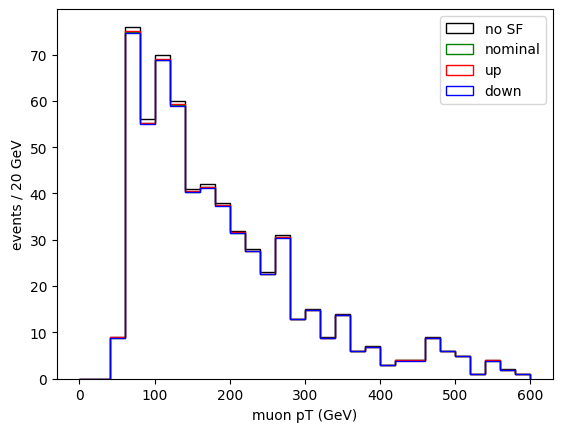

In [7]:
plt.hist(muon_pt,bins=30,range=(0,600),weights=genWeight,histtype="step",color="k",label="no SF")
plt.hist(muon_pt,bins=30,range=(0,600),weights=genWeight*leadmuon_sf,histtype="step",color="g",label="nominal")
plt.hist(muon_pt,bins=30,range=(0,600),weights=genWeight*leadmuon_sfup,histtype="step",color="r",label="up")
plt.hist(muon_pt,bins=30,range=(0,600),weights=genWeight*leadmuon_sfdn,histtype="step",color="b",label="down")
plt.legend()
plt.xlabel('muon pT (GeV)')
plt.ylabel('events / 20 GeV')
plt.show()

### Implement the pileup correction 

In [8]:
# Open the pileup correction file and acess the correction

with gzip.open("POG/LUM/2016postVFP_UL/puWeights.json.gz",'rt') as file:
    data = file.read().strip()
    evaluator = correctionlib._core.CorrectionSet.from_string(data)
    
pileupcorr = evaluator["Collisions16_UltraLegacy_goldenJSON"]

In [9]:
# Get the necessary inputs from data array

pu = signal['pileup']
# Extracts the pileup information from the 'signal' dataset.

pu_sf = [pileupcorr.evaluate(nTrueInts,"nominal") for nTrueInts in pu]
# Calculates the pileup scale factor (SF) for each event using the "nominal" correction.
# 'pileupcorr.evaluate' is called with the number of pileup interactions (nInts) and the "nominal" setting.
# This provides the standard pileup correction for each event.

pu_sfup = [pileupcorr.evaluate(nTrueInts,"up") for nTrueInts in pu]
# Calculates the pileup scale factor (SF) for each event using the "up" correction.
# 'pileupcorr.evaluate' is called with the number of pileup interactions (nInts) and the "up" setting.
# This accounts for the upward systematic uncertainty in pileup corrections, providing an estimate of the maximum deviation.

pu_sfdn = [pileupcorr.evaluate(nTrueInts,"down") for nTrueInts in pu]
# Calculates the pileup scale factor (SF) for each event using the "down" correction.
# 'pileupcorr.evaluate' is called with the number of pileup interactions (nInts) and the "down" setting.
# This accounts for the downward systematic uncertainty in pileup corrections, providing an estimate of the minimum deviation.

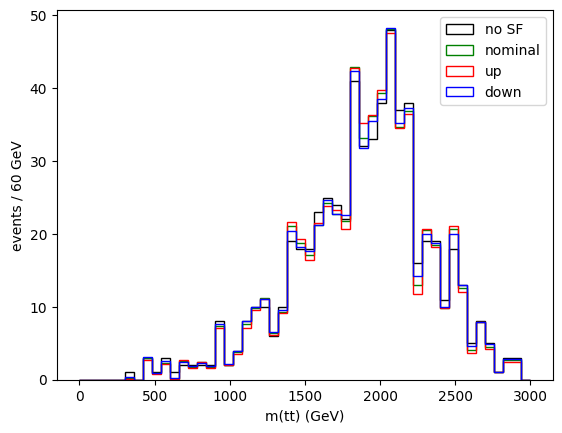

In [10]:
# Plot the Z’ mass with the pileup weight applied, and its uncertainty shifts
plt.hist(signal['mtt'],bins=50,range=(0,3000),weights=genWeight,histtype="step",color="k",label="no SF")
plt.hist(signal['mtt'],bins=50,range=(0,3000),weights=genWeight*pu_sf,histtype="step",color="g",label="nominal")
plt.hist(signal['mtt'],bins=50,range=(0,3000),weights=genWeight*pu_sfup,histtype="step",color="r",label="up")
plt.hist(signal['mtt'],bins=50,range=(0,3000),weights=genWeight*pu_sfdn,histtype="step",color="b",label="down")
plt.legend()
plt.xlabel('m(tt) (GeV)')
plt.ylabel('events / 60 GeV')
plt.savefig('histogram_pileup_corrections.png')
plt.show()

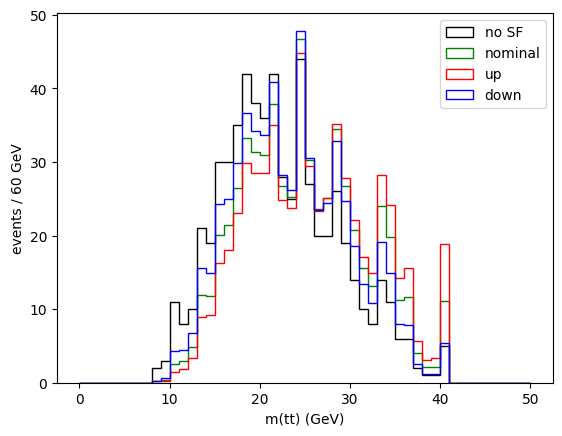

In [11]:
# Plot of the pileup reweighting uncertainties
plt.hist(pu,bins=50,range=(0,50),weights=genWeight,histtype="step",color="k",label="no SF")
plt.hist(pu,bins=50,range=(0,50),weights=genWeight*pu_sf,histtype="step",color="g",label="nominal")
plt.hist(pu,bins=50,range=(0,50),weights=genWeight*pu_sfup,histtype="step",color="r",label="up")
plt.hist(pu,bins=50,range=(0,50),weights=genWeight*pu_sfdn,histtype="step",color="b",label="down")
plt.legend()
plt.xlabel('m(tt) (GeV)')
plt.ylabel('events / 60 GeV')
plt.savefig('pileup_reweighting_uncertainties.png')
plt.show()